# RNA Preprocessing

In [2]:
#!pip install scvi-colab

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import scvi

Global seed set to 0
/home/icb/nina.sander/miniconda3/envs/gex/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/icb/nina.sander/miniconda3/envs/gex/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## Loading data

In [5]:
adata_all = sc.read('GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')

In [36]:
adata = adata_all[adata_all.obs.batch.isin(['s1d1'])]
#sc.pp.log1p(adata)
adata_gex = adata[:,adata.var_names[adata.var.feature_types.isin(['GEX'])]]

we can use scanpy functions to handle, filter, and manipulate the data. In our case, we might want to filter out peaks that are rarely detected, to make the model train faster:

In [37]:
print(adata_gex.shape)
# compute the threshold: 5% of the cells
min_cells = int(adata_gex.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata_gex, min_cells=min_cells)
print(adata_gex.shape)

(6224, 13431)


/home/icb/nina.sander/miniconda3/envs/gex/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


(6224, 7509)


In [38]:
sc.pp.normalize_per_cell(adata_gex, counts_per_cell_after=1e4)
sc.pp.log1p(adata_gex)
adata.raw = adata_gex  # keep full dimension safe

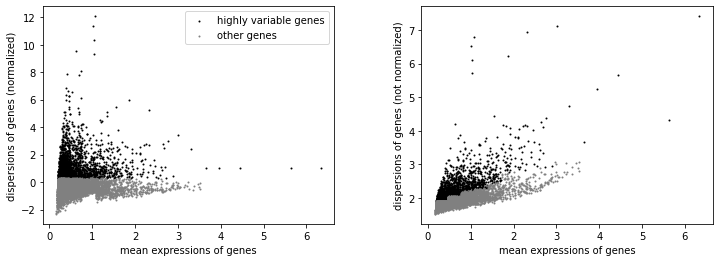

In [43]:
sc.pp.highly_variable_genes(adata_gex, n_top_genes = 2000)
sc.pl.highly_variable_genes(adata_gex)

## SCVI model

In [44]:
scvi.model.SCVI.setup_anndata(adata_gex, layer="counts")#, batch_key="tech")

In [45]:
vae = scvi.model.SCVI(adata_gex, n_layers=2, n_latent=30)

In [46]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [03:37<00:00,  1.87it/s, loss=3.51e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:37<00:00,  1.84it/s, loss=3.51e+03, v_num=1]


In [47]:
#vae.save("trained_model", overwrite=True)

## Visualisation and analysis of the latent space/ embedding

In [48]:
# Get latent embedding of cells
adata_gex.obsm["X_scVI"] = vae.get_latent_representation()

Use scanpy functions to cluster and visualize our latent space:

In [49]:
#!pip install pymde

In [50]:
from scvi.model.utils import mde
adata_gex.obsm["X_mde"] = mde(adata_gex.obsm["X_scVI"])

/home/icb/nina.sander/miniconda3/envs/gex/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


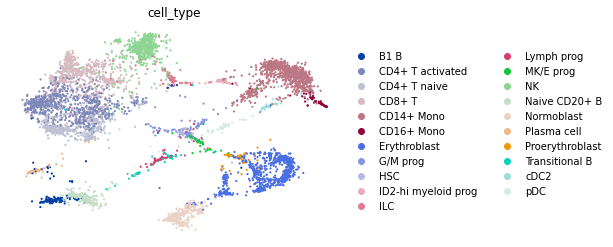

In [51]:
sc.pl.embedding(
    adata_gex,
    basis="X_mde",
    color=["cell_type"],
    frameon=False,
    #ncols=1,
)

/home/icb/nina.sander/miniconda3/envs/gex/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


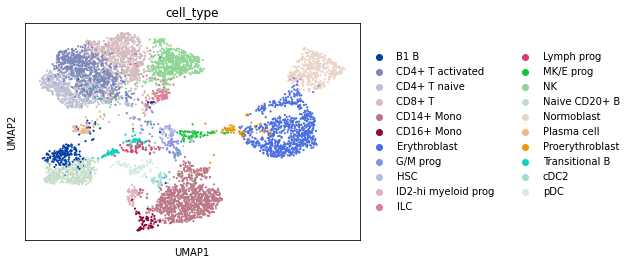

In [52]:
sc.pp.neighbors(adata_gex, use_rep = 'X_scVI')
sc.tl.umap(adata_gex)
sc.pl.umap(adata_gex, color = 'cell_type')

## Save data as h5ad file

In [53]:
adata_gex.write('rna_scVI.h5ad')

In [109]:
rna = sc.read('rna_scVI.h5ad')
rna

AnnData object with n_obs × n_vars = 6224 × 7509
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'n_counts', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm'
    uns: 'ATAC_gene_activity_var_names', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'dataset_id', 'genome', 'hvg', 'log1p', 'neighbors', 'organism', 'umap'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap',

In [110]:
cluster = {'B1 B': 0, 'CD14+ Mono':1, 'CD16+ Mono':2, 'CD4+ T activated':3,
       'CD4+ T naive':4, 'CD8+ T':5, 'Erythroblast':6, 'G/M prog':7, 'HSC':8,
       'ID2-hi myeloid prog':9, 'ILC':10, 'Lymph prog':11, 'MK/E prog':12, 'NK':13,
       'Naive CD20+ B':14, 'Normoblast':15, 'Plasma cell':16, 'Proerythroblast':17,
       'Transitional B':18, 'cDC2':19, 'pDC':20}
rna.obs['cluster'] = rna.obs['cell_type'].map(cluster).astype('category')

In [111]:
np.unique(rna.X.A[0,:])

array([0.       , 2.1129644, 2.7437685, 3.1275578, 3.4042232, 3.620698 ,
       3.798549 , 3.9494941, 4.0806146, 4.300373 , 4.394449 , 4.882113 ,
       4.9867153, 5.0814047], dtype=float32)

In [112]:
#sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.normalize_per_cell(rna, counts_per_cell_after=1e4)
sc.pp.log1p(rna)

In [114]:
np.unique(rna.X[0,:].A)

array([0.       , 2.39407  , 2.6341066, 2.756179 , 2.8357666, 2.8939023,
       2.9392593, 2.9762037, 3.007224 , 3.0571492, 3.0777826, 3.1784067,
       3.1987321, 3.2167816], dtype=float32)

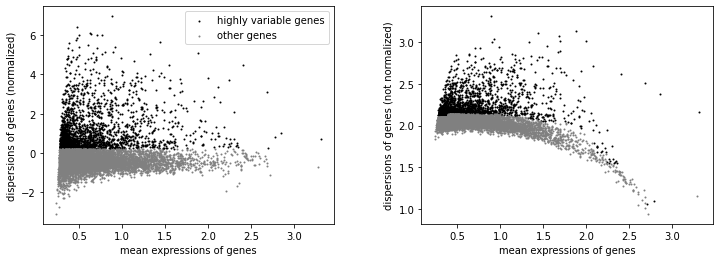

In [116]:
sc.pp.highly_variable_genes(rna, n_top_genes = 2000)
sc.pl.highly_variable_genes(rna)

In [117]:
np.sum(rna.var.highly_variable)

2000

In [118]:
sc.pp.scale(rna, max_value=10)

/home/icb/nina.sander/miniconda3/envs/gex/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


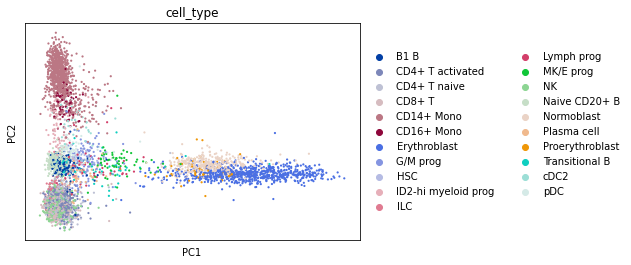

In [119]:
sc.tl.pca(rna, svd_solver='arpack')
sc.pl.pca(rna, color='cell_type')

/home/icb/nina.sander/miniconda3/envs/gex/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


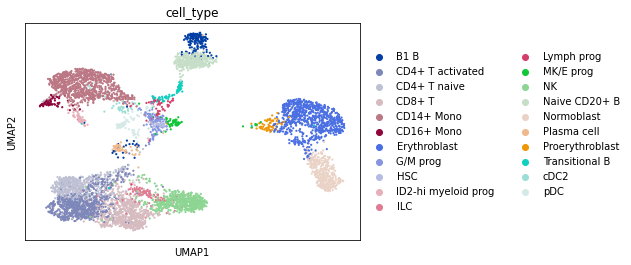

In [120]:
sc.pp.neighbors(rna, use_rep = 'X_pca')
sc.tl.umap(rna)
sc.pl.umap(rna, color='cell_type')

In [121]:
rna.write("rna-emb.h5ad")